In [74]:
import numpy as np
import pandas as pd
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import cufflinks as cf
from cufflinks.offline import go_offline
from plotly.offline import plot , iplot , init_notebook_mode , download_plotlyjs
import plotly.graph_objects as go 

from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV

import pickle
import os

In [3]:
file_path = os.path.abspath(os.path.dirname('__file__'))

In [4]:
flight_df = pd.read_excel(os.path.join(file_path,'Data_Train.xlsx'))

flight_df

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302
...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,9/04/2019,Kolkata,Banglore,CCU → BLR,19:55,22:25,2h 30m,non-stop,No info,4107
10679,Air India,27/04/2019,Kolkata,Banglore,CCU → BLR,20:45,23:20,2h 35m,non-stop,No info,4145
10680,Jet Airways,27/04/2019,Banglore,Delhi,BLR → DEL,08:20,11:20,3h,non-stop,No info,7229
10681,Vistara,01/03/2019,Banglore,New Delhi,BLR → DEL,11:30,14:10,2h 40m,non-stop,No info,12648


# Clean the data

In [5]:
flight_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [6]:
flight_df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [7]:
flight_df[flight_df['Route'].isnull()]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
9039,Air India,6/05/2019,Delhi,Cochin,NaN,09:45,09:25 07 May,23h 40m,NaN,No info,7480


In [8]:
flight_df.dropna(inplace=True)

# Data Preprocessing and Attribute Extract

In [9]:
flight_copy_df = flight_df.copy()

In [10]:
for feature in ['Date_of_Journey','Dep_Time','Arrival_Time']:
    flight_copy_df[feature] = pd.to_datetime(flight_copy_df[feature])

C:\Users\Ben Leong\AppData\Local\Temp\ipykernel_49832\1004299893.py:2: UserWarning:

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.



In [11]:
flight_copy_df.dtypes

Airline                    object
Date_of_Journey    datetime64[ns]
Source                     object
Destination                object
Route                      object
Dep_Time           datetime64[ns]
Arrival_Time       datetime64[ns]
Duration                   object
Total_Stops                object
Additional_Info            object
Price                       int64
dtype: object

In [12]:
flight_copy_df["Journey_day"] = flight_copy_df["Date_of_Journey"].dt.day

flight_copy_df["Journey_month"] = flight_copy_df["Date_of_Journey"].dt.month

flight_copy_df["Journey_year"] = flight_copy_df["Date_of_Journey"].dt.year

In [13]:
flight_copy_df

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Journey_year
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,2024-03-24 22:20:00,2024-03-22 01:10:00,2h 50m,non-stop,No info,3897,24,3,2019
1,Air India,2019-01-05,Kolkata,Banglore,CCU → IXR → BBI → BLR,2024-03-24 05:50:00,2024-03-24 13:15:00,7h 25m,2 stops,No info,7662,5,1,2019
2,Jet Airways,2019-09-06,Delhi,Cochin,DEL → LKO → BOM → COK,2024-03-24 09:25:00,2024-06-10 04:25:00,19h,2 stops,No info,13882,6,9,2019
3,IndiGo,2019-12-05,Kolkata,Banglore,CCU → NAG → BLR,2024-03-24 18:05:00,2024-03-24 23:30:00,5h 25m,1 stop,No info,6218,5,12,2019
4,IndiGo,2019-01-03,Banglore,New Delhi,BLR → NAG → DEL,2024-03-24 16:50:00,2024-03-24 21:35:00,4h 45m,1 stop,No info,13302,3,1,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,2019-09-04,Kolkata,Banglore,CCU → BLR,2024-03-24 19:55:00,2024-03-24 22:25:00,2h 30m,non-stop,No info,4107,4,9,2019
10679,Air India,2019-04-27,Kolkata,Banglore,CCU → BLR,2024-03-24 20:45:00,2024-03-24 23:20:00,2h 35m,non-stop,No info,4145,27,4,2019
10680,Jet Airways,2019-04-27,Banglore,Delhi,BLR → DEL,2024-03-24 08:20:00,2024-03-24 11:20:00,3h,non-stop,No info,7229,27,4,2019
10681,Vistara,2019-01-03,Banglore,New Delhi,BLR → DEL,2024-03-24 11:30:00,2024-03-24 14:10:00,2h 40m,non-stop,No info,12648,3,1,2019


In [14]:
def extract_hr_min(df, col):
    df[col+"_hour"] = df[col].dt.hour
    df[col+"_minute"] = df[col].dt.minute

In [15]:
extract_col = ['Dep_Time','Arrival_Time']

for feature in extract_col:
    extract_hr_min(flight_copy_df,feature)

In [16]:
flight_copy_df.drop(extract_col, axis=1, inplace=True)

flight_copy_df

,Airline,Date_of_Journey,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Journey_year,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,2019,22,20,1,10
1,Air India,2019-01-05,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,5,1,2019,5,50,13,15
2,Jet Airways,2019-09-06,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2 stops,No info,13882,6,9,2019,9,25,4,25
3,IndiGo,2019-12-05,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,5,12,2019,18,5,23,30
4,IndiGo,2019-01-03,Banglore,New Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,3,1,2019,16,50,21,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,2019-09-04,Kolkata,Banglore,CCU → BLR,2h 30m,non-stop,No info,4107,4,9,2019,19,55,22,25
10679,Air India,2019-04-27,Kolkata,Banglore,CCU → BLR,2h 35m,non-stop,No info,4145,27,4,2019,20,45,23,20
10680,Jet Airways,2019-04-27,Banglore,Delhi,BLR → DEL,3h,non-stop,No info,7229,27,4,2019,8,20,11,20
10681,Vistara,2019-01-03,Banglore,New Delhi,BLR → DEL,2h 40m,non-stop,No info,12648,3,1,2019,11,30,14,10


In [17]:
def preprocess_dur(x):
    if 'h' not in x:
        x = '0h'+' '+x
    elif 'm' not in x:
        x = x+' '+'0m'
        
    return x

In [18]:
flight_copy_df['Duration'] = flight_copy_df['Duration'].apply(preprocess_dur)

flight_copy_df['Duration_hours'] = pd.to_timedelta(flight_copy_df['Duration']).dt.components.hours
flight_copy_df['Duration_mins'] = pd.to_timedelta(flight_copy_df['Duration']).dt.components.minutes

# Exploratory Data Analysis

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Early Morning'),
  Text(1, 0, 'Evening'),
  Text(2, 0, 'Morning'),
  Text(3, 0, 'Noon'),
  Text(4, 0, 'Night'),
  Text(5, 0, 'Late Night')])

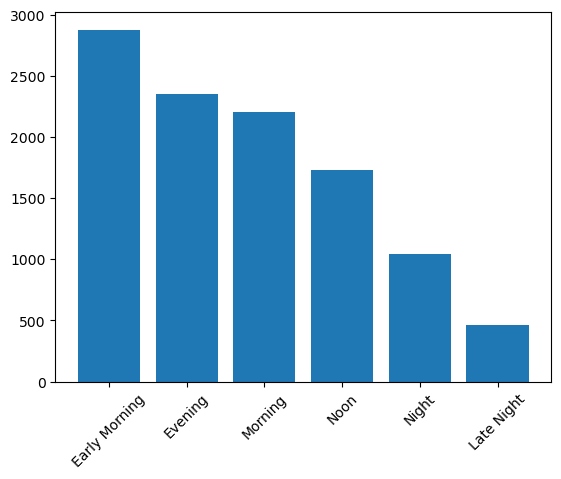

In [19]:
dep_time_cat = dict(Counter(['Early Morning' if t in range(5,9) else
                             'Morning' if t in range(9,13) else
                             'Noon' if t in range(13,17) else
                             'Evening' if t in range(17,21) else
                             'Night' if t in range (21, 25) else
                             'Late Night' for t in flight_copy_df['Dep_Time_hour']]).most_common())

plt.bar(dep_time_cat.keys(), dep_time_cat.values())
plt.xticks(rotation=45)

In [20]:
init_notebook_mode(connected=True)
cf.go_offline()

plotly.offline.iplot([go.Bar(x=list(dep_time_cat.keys()), y=list(dep_time_cat.values()))])

<Axes: xlabel='Duration_total_mins', ylabel='Price'>

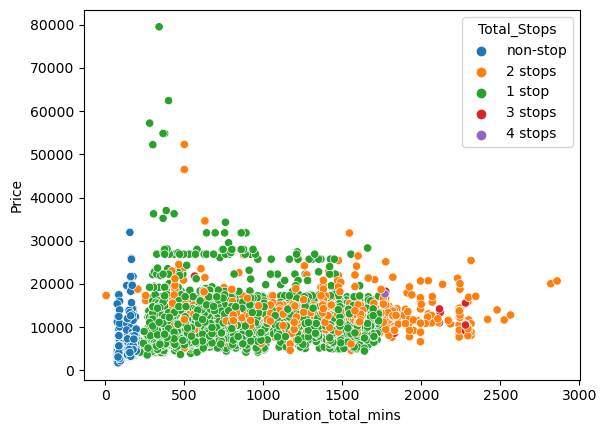

In [21]:
flight_copy_df['Duration_total_mins'] = flight_copy_df['Duration'].str.replace('h' ,"*60").str.replace(' ' , '+').str.replace('m' , "*1").apply(eval)
#flight_copy_df['Duration_total_mins'] = flight_copy_df['Duration_hours']*60+flight_copy_df['Duration_mins']

sns.scatterplot(x='Duration_total_mins', y='Price', hue='Total_Stops', data=flight_copy_df)

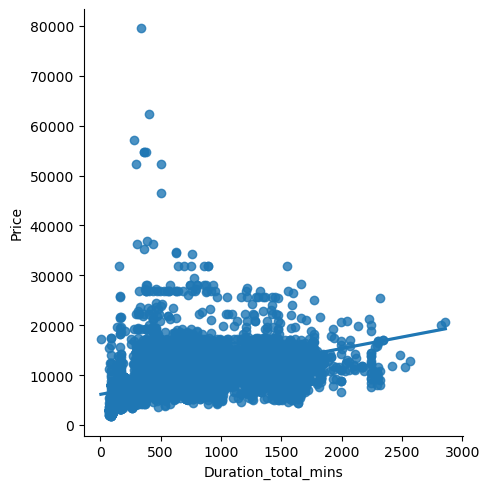

In [22]:
sns.lmplot(x='Duration_total_mins', y='Price', data=flight_copy_df)

In [23]:
flight_copy_df[flight_copy_df['Airline']=='Jet Airways'].groupby('Route').size().sort_values(ascending=False)

Route
CCU → BOM → BLR          930
DEL → BOM → COK          875
BLR → BOM → DEL          385
BLR → DEL                382
CCU → DEL → BLR          300
BOM → HYD                207
DEL → JAI → BOM → COK    207
DEL → AMD → BOM → COK    141
DEL → IDR → BOM → COK     86
DEL → NAG → BOM → COK     61
DEL → ATQ → BOM → COK     38
DEL → COK                 34
DEL → BHO → BOM → COK     29
DEL → BDQ → BOM → COK     28
DEL → LKO → BOM → COK     25
DEL → JDH → BOM → COK     23
CCU → GAU → BLR           22
DEL → MAA → BOM → COK     16
DEL → IXC → BOM → COK     13
BLR → MAA → DEL           10
BLR → BDQ → DEL            8
DEL → UDR → BOM → COK      7
BOM → DEL → HYD            5
CCU → BOM → PNQ → BLR      4
BLR → BOM → JDH → DEL      3
DEL → DED → BOM → COK      2
BOM → BDQ → DEL → HYD      2
DEL → CCU → BOM → COK      1
BOM → VNS → DEL → HYD      1
BOM → UDR → DEL → HYD      1
BOM → JDH → DEL → HYD      1
BOM → IDR → DEL → HYD      1
BOM → DED → DEL → HYD      1
dtype: int64

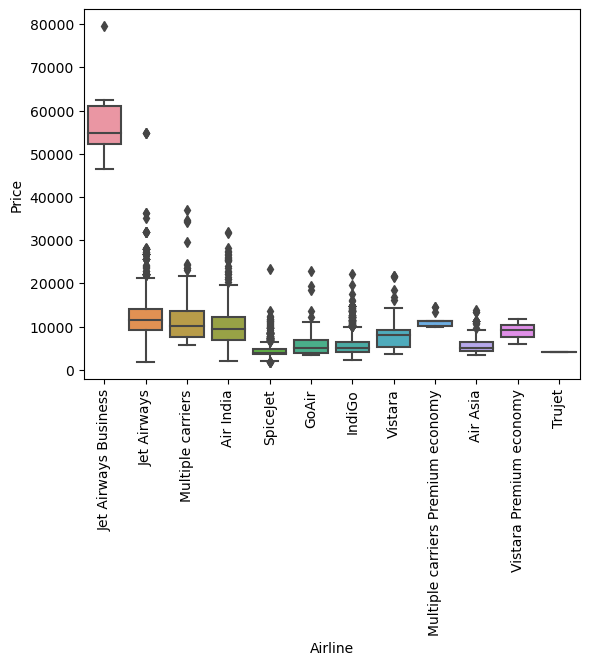

In [24]:
sns.boxplot(x='Airline', y='Price', data=flight_copy_df.sort_values('Price',ascending=False))
plt.xticks(rotation='vertical')
plt.show()

# Feature Engineering

In [25]:
num_features = [col for col in flight_copy_df.columns if flight_copy_df[col].dtype != 'object']
cat_features = [col for col in flight_copy_df.columns if flight_copy_df[col].dtype == 'object']

In [26]:
cat_features

['Airline',
 'Source',
 'Destination',
 'Route',
 'Duration',
 'Total_Stops',
 'Additional_Info']

In [27]:
#One hot encoding

for s in flight_copy_df['Source'].unique():
    flight_copy_df['Source_'+s] = flight_copy_df['Source'].apply(lambda x:1 if x == s else 0)

In [28]:
#Target Guided Ordinal Encoding

def TGOE(df, col, target):
    new = df.groupby(col)[target].mean().sort_values().index
    new_dict = {key:index for index,key in enumerate(new)}
    df[col] = df[col].map(new_dict)

In [29]:
flight_copy_df['Destination'].replace('New Delhi', 'Delhi', inplace=True)

for enc_col in ['Airline','Destination']:
    TGOE(flight_copy_df, enc_col, 'Price')

In [30]:
#Label Encoding

stops = {'non-stop':0, '2 stops':2, '1 stop':1, '3 stops':3, '4 stops':4}
flight_copy_df['Total_Stops'] = flight_copy_df['Total_Stops'].map(stops)

In [31]:
flight_copy_df

,Airline,Date_of_Journey,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_day,...,Arrival_Time_hour,Arrival_Time_minute,Duration_hours,Duration_mins,Duration_total_mins,Source_Banglore,Source_Kolkata,Source_Delhi,Source_Chennai,Source_Mumbai
0,3,2019-03-24,Banglore,2,BLR → DEL,2h 50m,0,No info,3897,24,...,1,10,2,50,170,1,0,0,0,0
1,7,2019-01-05,Kolkata,3,CCU → IXR → BBI → BLR,7h 25m,2,No info,7662,5,...,13,15,7,25,445,0,1,0,0,0
2,10,2019-09-06,Delhi,4,DEL → LKO → BOM → COK,19h 0m,2,No info,13882,6,...,4,25,19,0,1140,0,0,1,0,0
3,3,2019-12-05,Kolkata,3,CCU → NAG → BLR,5h 25m,1,No info,6218,5,...,23,30,5,25,325,0,1,0,0,0
4,3,2019-01-03,Banglore,2,BLR → NAG → DEL,4h 45m,1,No info,13302,3,...,21,35,4,45,285,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,2,2019-09-04,Kolkata,3,CCU → BLR,2h 30m,0,No info,4107,4,...,22,25,2,30,150,0,1,0,0,0
10679,7,2019-04-27,Kolkata,3,CCU → BLR,2h 35m,0,No info,4145,27,...,23,20,2,35,155,0,1,0,0,0
10680,10,2019-04-27,Banglore,2,BLR → DEL,3h 0m,0,No info,7229,27,...,11,20,3,0,180,1,0,0,0,0
10681,5,2019-01-03,Banglore,2,BLR → DEL,2h 40m,0,No info,12648,3,...,14,10,2,40,160,1,0,0,0,0


In [32]:
#Remove unnecessary columns

flight_copy_df['Additional_Info'].value_counts(normalize=True) 

flight_copy_df['Journey_year'].unique()

drop_col = ['Date_of_Journey', 'Source', 'Route', 'Duration', 'Additional_Info', 'Journey_year', 'Duration_total_mins']
flight_copy_df.drop(columns=drop_col, axis=1, inplace=True)

In [33]:
flight_copy_df

,Airline,Destination,Total_Stops,Price,Journey_day,Journey_month,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute,Duration_hours,Duration_mins,Source_Banglore,Source_Kolkata,Source_Delhi,Source_Chennai,Source_Mumbai
0,3,2,0,3897,24,3,22,20,1,10,2,50,1,0,0,0,0
1,7,3,2,7662,5,1,5,50,13,15,7,25,0,1,0,0,0
2,10,4,2,13882,6,9,9,25,4,25,19,0,0,0,1,0,0
3,3,3,1,6218,5,12,18,5,23,30,5,25,0,1,0,0,0
4,3,2,1,13302,3,1,16,50,21,35,4,45,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,2,3,0,4107,4,9,19,55,22,25,2,30,0,1,0,0,0
10679,7,3,0,4145,27,4,20,45,23,20,2,35,0,1,0,0,0
10680,10,2,0,7229,27,4,8,20,11,20,3,0,1,0,0,0,0
10681,5,2,0,12648,3,1,11,30,14,10,2,40,1,0,0,0,0


# Outlier Detection

In [34]:
def plot(df, target):
    fig, (ax1,ax2,ax3) = plt.subplots(3,1)
    sns.histplot(df[target], ax=ax1, kde=True)
    sns.boxplot(df[target], ax=ax2, orient='h')
    sns.histplot(df[target], ax=ax3)

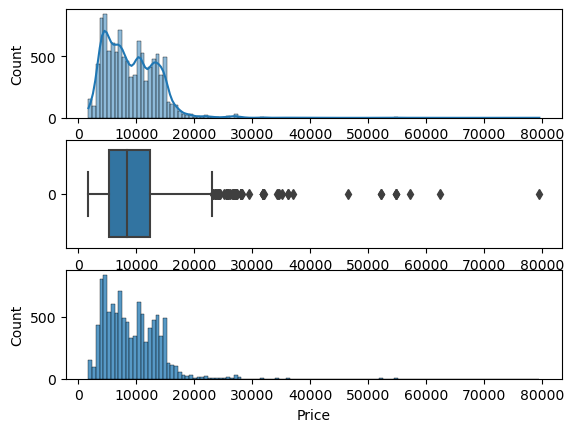

In [35]:
plot(flight_copy_df,'Price')

In [36]:
#Convert outliers (defined by IQR approach) to median value 

q1 = flight_copy_df['Price'].quantile(0.25)
q3 = flight_copy_df['Price'].quantile(0.75)

iqr = q3-q1

max_val = q3 + 1.5*iqr
min_val = q1 - 1.5*iqr

In [37]:
flight_copy_df['Price'] = np.where(flight_copy_df['Price']>=max_val, flight_copy_df['Price'].median(), flight_copy_df['Price'])

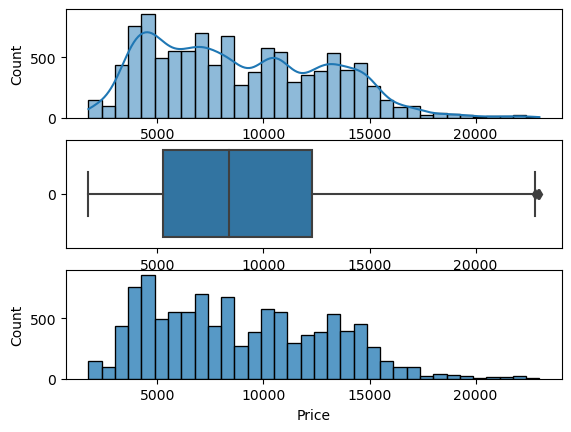

In [38]:
plot(flight_copy_df,'Price')

# Feature Selection

In [43]:
X = flight_copy_df.drop(['Price'],axis=1)

y = flight_copy_df['Price']

imp = mutual_info_regression(X,y)
imp_df = pd.DataFrame(imp, index=X.columns)
imp_df.columns = ['Importance']
imp_df.sort_values('Importance',ascending=False)

,Importance
Destination,0.996148
Airline,0.975069
Total_Stops,0.782131
Source_Delhi,0.513035
Source_Kolkata,0.463635
Duration_hours,0.415682
Arrival_Time_hour,0.397924
Source_Banglore,0.388359
Arrival_Time_minute,0.351857
Duration_mins,0.343327


# Machine Learning Model Construction (Random Forest)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [46]:
rf_model = RandomForestRegressor()

RandomForestRegressor()

In [80]:
#Hyperparameter tuning

n_estimators = [int(x) for x in np.linspace(100, 1200, 5)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 30, 5)]
min_samples_split = [int(x) for x in np.linspace(5, 100, 5)]

rf_hyper_grid = {
    'n_estimators' : n_estimators,
    'max_features' : max_features,
    'max_depth' : max_depth,
    'min_samples_split' : min_sample_split
}

In [85]:
rf_model_hyper = RandomizedSearchCV(estimator=rf_model, param_distributions=rf_hyper_grid, cv=5, n_jobs=-1, verbose=2)

In [86]:
rf_model_hyper.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\Ben Leong\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [5, 11, 17, 23, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [5, 28, 52, 76,
                                                              100],
                                        'n_estimators': [100, 375, 650, 925,
                                                         1200]},
                   verbose=2)

In [88]:
print(rf_model_hyper.best_params_)
print(rf_model_hyper.best_estimator_)
print(rf_model_hyper.best_score_)

{'n_estimators': 375, 'min_samples_split': 5, 'max_features': 'auto', 'max_depth': 11}
RandomForestRegressor(max_depth=11, max_features='auto', min_samples_split=5,
                      n_estimators=375)
0.8161138490675299


In [89]:
rf_pred = rf_model_hyper.predict(X_test)

metrics.r2_score(rf_pred, y_test)

0.7987608384762186

In [90]:
#Save the model

rf_file = open('rf.pkl','wb')

pickle.dump(rf_model_hyper, rf_file)

In [92]:
#Load the model

rf_model_file = open('rf.pkl','rb')

rf_model_load = pickle.load(rf_model_file)

In [70]:
#Define own evaluation metrics (MAPE)

def mape(y_pred, y_true):
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

In [93]:
#Automate ML pipeline

def ml_pipeline(ml_model, X_train, X_test, y_train, y_test, hyper_tune=None, cv=5):
    if hyper_tune != None:
        fitmodel_tune = RandomizedSearchCV(estimator=rf_model, param_distributions=rf_hyper_grid, cv=cv, verbose=2)
        fitmodel = fitmodel_tune.fit(X_train, y_train)
    else:
        fitmodel = ml_model.fit(X_train, y_train)
    print('Training score is: {}'.format(fitmodel.score(X_train, y_train)))
    print('\n')
    y_pred = fitmodel.predict(X_test)
    print('Predictions are: {}'.format(y_pred))
    print('\n')
    print('R2 score is: {}'.format(metrics.r2_score(y_test, y_pred)))
    print('MAE score is: {}'.format(metrics.mean_absolute_error(y_test, y_pred)))
    print('MSE score is: {}'.format(metrics.mean_squared_error(y_test, y_pred)))
    print('RMSE score is: {}'.format(np.sqrt(metrics.r2_score(y_test, y_pred))))
    print('MAPE score is: {}'.format(mape(y_test, y_pred)))
    sns.distplot(y_test-y_pred)

Training score is: 0.9489396412510461


Predictions are: [11299.90083333  4911.91        7218.91       ... 11349.125
 13388.69066667  8232.30466667]


R2 score is: 0.8054505315555256
MAE score is: 1149.5559881271126
MSE score is: 3162385.2104260204
RMSE score is: 0.8974689585470494
MAPE score is: 12.50611164745693


C:\Users\Ben Leong\AppData\Local\Temp\ipykernel_49832\1521103603.py:19: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




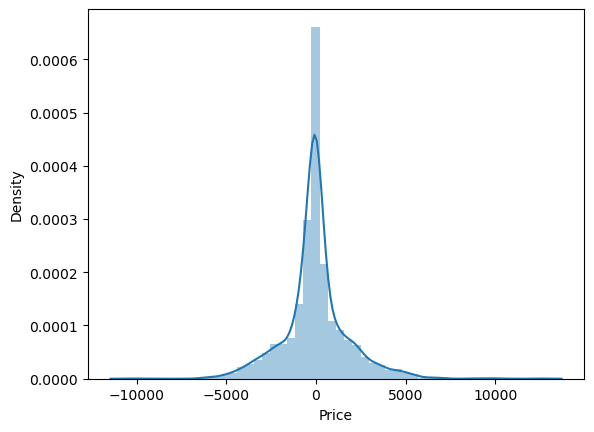

In [94]:
ml_pipeline(rf_model, X_train, X_test, y_train, y_test)